# IMDB-dataset learning with data cartography guided curriculum learning

## Section 0: Notebook setup

### 0.1: Imports

In [1]:
### Utility
import os
from pathlib import Path
import urllib

### Datascience
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

### Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Nltk download
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 0.2: Configuration setup

In [2]:
# Set of constant used, you can choose which to use below
SEEDS = [42, 69, 420, 42069, 69420]
CARD_DICT = {"sentence":"sentence-transformers/bert-base-nli-mean-tokens",
             "tiny":"prajjwal1/bert-tiny"
            }

In [3]:
# Constant setting --- you can change these
SEED_IDX = 0
CARD_KEY = "tiny"
MAX_LEN = 256
TRAIN_BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 2e-5

In [4]:
# Constant derivation settings --- DO NOT TOUCH
SEED = SEEDS[SEED_IDX]
CARD = CARD_DICT.get(CARD_KEY, "prajjwal1/bert-tiny")
torch.manual_seed(SEED)
np.random.seed(SEED);

### 0.3 Utility functions

#### 0.3.1 Dataset class definition

In [5]:
class IMDB_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Description
        self.tokenizer = tokenizer
        self.targets = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'index': index,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

#### 0.3.2: Model functions

##### Trainer function definition

In [6]:
def trainer(model, device, optimizer, loss_fn, loader, epochs, train_dyn={}, c_old:int=0, c_max:int=0, loss_lim:float=.0):
    counter = max(c_old, 0)
    losses = []
    results = {}
    for epoch in range(epochs):
        model.train()
        print(f'EPOCH {epoch + 1}/{epochs}...')
        for _,data in enumerate(loader):
            counter += 1
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids).logits

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (float(loss.item()) < loss_lim) or counter == c_max:
                break
        # Evaluation done on train dataset for data cartography purposes
        print('Data Cartography sample generation...')
        model.eval()
        with torch.no_grad():
            for _, data in enumerate(loader):
                index = data['index']
                ids = data['ids'].to(device, dtype=torch.long)
                mask = data['mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)

                outputs = model(ids, mask, token_type_ids).logits
                index = index.cpu().detach().numpy()
                fin_targets = targets.cpu().detach().numpy()
                fin_outputs = outputs.cpu().detach().numpy()

                for i in range(len(index)):
                  results[index[i]] = {'prob':fin_outputs[i], 'corr':fin_targets[i]}
        compute_prob(results,train_dyn)
        if (float(loss.item()) < loss_lim) or counter == c_max:
            break
    return losses, counter

##### Evaluation function definition

In [7]:
def evaluation_run(model, loader, device):
    results = []
    for _, data in enumerate(loader):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

        outputs = model(ids, mask, token_type_ids).logits
        fin_outputs = torch.round(torch.nn.Softmax(dim=-1)(outputs)).cpu().detach().numpy()

        results.extend(fin_outputs)
    return results

#### 0.3.3 Plotting functions

In [8]:
def plot_data_map(dataframe: pd.DataFrame,
                  plot_dir: os.path,
                  hue_metric: str = 'correct.',
                  title: str = 'IMDB-curr',
                  model: str = 'BERT-tiny',
                  show_hist: bool = False,
                  max_instances_to_plot = 55000):
    # Set style.
    sns.set(style='whitegrid', font_scale=1.6, context='paper')


    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    #num_hues=4
    hue_order = sorted(set(dataframe[hue].unique().tolist()))
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = plt.figure(figsize=(14, 10), )
        gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[:, 0])

    # Make the scatterplot.
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30,
                           hue_order=hue_order)

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    func_annotate = lambda  text, xyc, bbc : ax0.annotate(text,
                                                          xy=xyc,
                                                          xycoords="axes fraction",
                                                          fontsize=15,
                                                          color='black',
                                                          va="center",
                                                          ha="center",
                                                          rotation=350,
                                                           bbox=bb(bbc))
    an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
    an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
    an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')

    if show_hist:
        plot.set_title(f"{title}-{model} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[2, 1])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        plott1[0].set_ylabel('density')

        plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('density')

    fig.tight_layout()
    filename = f'{plot_dir}/{title}_{model}.pdf'# if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)

In [9]:
def annotate(df):
  df2=df.copy()
  for i in range(len(df)):
    if df2.iloc[i]['confidence']>0.6 and df2.iloc[i]['variability']<0.15:
      df2.loc[i,'ann']='easy'
    elif df2.iloc[i]['confidence']<0.5 and df2.iloc[i]['variability']<0.15:
      df2.loc[i,'ann']='hard'
    else:
      df2.loc[i,'ann']='ambigous'
  return df2

In [40]:
def hard_to_learn(df,labels,threshold=0.25):
  diz={i:0 for i in labels}  #-> return the percentage of hard to learn sample per class
  for i in range(len(df)):
    if df.iloc[i]['c*(1-v)']<threshold:
      for k in labels:
        if df.iloc[i][k]==1:
          diz[k]+=1
  for j in labels:
    diz[j] /= df[j].sum()

  plt.bar(diz.keys(),diz.values(),color='blue')

  plt.xticks(rotation='vertical')

# Add labels and title
  plt.xlabel('Class')
  plt.ylabel('Value')
  plt.title('Percentage of Hard To Learn')

#### 0.3.4 Data cartography functions

In [11]:
def check(A,B):
  for a,b in zip(A,B):
    if a!=b:
      return False
  return True

In [12]:
def compute_prob(results,train_dyn,truth_threshold=0.5):
    # results a dict containing the results obtained by the model
    # train_dyn is a dict updated by this function
    # it contains the probabilities and the true_trend
    # truth_threshold is a float to set the thr. after the sigmoid
    for i,logits in zip(results.keys(),results.values()):

        probs = torch.sigmoid(torch.Tensor(logits['prob'])).numpy() # element-wise sigmoid
        true_class = np.where(np.array((logits['corr'])) == 1)[0] # indexes  of true classes

        true_class_prob =[probs[i] for i in true_class]  # the probability of having the right class
        prediction = np.where(probs > truth_threshold)[0] # predicted classes
        is_correct=check(prediction,true_class)
        if i in train_dyn.keys():
            train_dyn[i]['prob'].append(true_class_prob)
            train_dyn[i]['corr'].append(is_correct)
        else:
            train_dyn[i]={}
            train_dyn[i]['prob']=[true_class_prob]
            train_dyn[i]['corr']=[is_correct]

In [13]:
def compute_metrics(train_dyn):
    confidence={}
    variability={}
    correctness={}
    variability_func = lambda conf: np.std(conf)
    for i in (train_dyn.keys()):
        correctness[i] = sum(train_dyn[i]['corr'])
        confidence[i] = np.mean(train_dyn[i]['prob'])  #by definition
        variability[i] = variability_func(train_dyn[i]['prob'])
    column_names = ['index',
                    'confidence',
                    'variability',
                    'correctness',
                  ]
    df=pd.DataFrame([[i,
                        confidence[i],
                        variability[i],
                        correctness[i],
                        ] for i in train_dyn.keys()], columns=column_names)

    return df.set_index('index')

## Section 1: Dataset import

In [14]:
!pip install -q kaggle

In [15]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [16]:
## Reset environment
!rm -rf ./imdb-dataset

In [17]:
!kaggle datasets download -d 'hijest/genre-classification-dataset-imdb'
!mkdir ./imdb-dataset
!unzip -jq '/content/genre-classification-dataset-imdb.zip' -d ./imdb-dataset/

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
genre-classification-dataset-imdb.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
train = pd.read_csv("./imdb-dataset/train_data.txt", sep = ' ::: ', index_col = [0], names = ["Id", "Title", "Genre", "Description"])
test = pd.read_csv("./imdb-dataset/test_data_solution.txt", sep = ' ::: ', index_col = [0], names = ["Id", "Title", "Genre", "Description"])

<ipython-input-18-c3223e509244>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train = pd.read_csv("./imdb-dataset/train_data.txt", sep = ' ::: ', index_col = [0], names = ["Id", "Title", "Genre", "Description"])
<ipython-input-18-c3223e509244>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test = pd.read_csv("./imdb-dataset/test_data_solution.txt", sep = ' ::: ', index_col = [0], names = ["Id", "Title", "Genre", "Description"])


In [19]:
train, _ = train_test_split(train, test_size=0.9)

labels = train.Genre.unique()
one_hot = pd.get_dummies(train['Genre']).astype(float)
train.drop(columns=['Genre'], inplace=True)
train = train.join(one_hot)
train.reset_index(inplace=True)
train.drop(columns=['Id'], inplace=True)

In [20]:
labels_test = test.Genre.unique()
one_hot_test = pd.get_dummies(test['Genre']).astype(float)
test.drop(columns=['Genre'], inplace=True)
test = test.join(one_hot_test)
test.reset_index(inplace=True)
test.drop(columns=['Id'], inplace=True)

In [21]:
train.head()

,Title,Description,action,adult,adventure,animation,biography,comedy,crime,documentary,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Are You Sure I'm Korean? (????),"The history of Korean adoptions in the USA, th...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Star Trek: The Next Generation - Survive and S...,An in-depth exploration on the Klingons and th...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Last of the Duanes (1924),Buck Duane is on the run after killing his fat...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Una mujer decente (1950),This is about a woman who could not find her o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"After You've Gone, Honey (2010)",Existing within the possibilities of the theat...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
test.head()

,Title,Description,action,adult,adventure,animation,biography,comedy,crime,documentary,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Off the Beaten Track (2010),One year in the life of Albin and his family o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Er nu zhai (1955),Before he was known internationally as a marti...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Section 2: Baseline model generation

### 2.1: Tokenizer declaration

In [23]:
tokenizer = AutoTokenizer.from_pretrained(CARD)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 2.2: Model definition

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model.bert.embeddings.parameters():
    param.requires_grad = False
for param in model.bert.encoder.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer.zero_grad()
loss_fn = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.3: Model instantiation

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### 2.3: train and test loader creation

In [26]:
train_set = IMDB_Dataset(train, tokenizer, max_len=MAX_LEN)
loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
test_set = IMDB_Dataset(test, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_set, batch_size=TRAIN_BATCH_SIZE, shuffle=False, pin_memory=True)

## Section 3: Training and validation

### 3.1: Training

In [27]:
train_dyn = {}
history, train_steps = trainer(model, device, optimizer, loss_fn, loader, EPOCHS*3, train_dyn)

EPOCH 1/300...
Data Cartography sample generation...
EPOCH 2/300...
Data Cartography sample generation...
EPOCH 3/300...
Data Cartography sample generation...
EPOCH 4/300...
Data Cartography sample generation...
EPOCH 5/300...
Data Cartography sample generation...
EPOCH 6/300...
Data Cartography sample generation...
EPOCH 7/300...
Data Cartography sample generation...
EPOCH 8/300...
Data Cartography sample generation...
EPOCH 9/300...
Data Cartography sample generation...
EPOCH 10/300...
Data Cartography sample generation...
EPOCH 11/300...
Data Cartography sample generation...
EPOCH 12/300...
Data Cartography sample generation...
EPOCH 13/300...
Data Cartography sample generation...
EPOCH 14/300...
Data Cartography sample generation...
EPOCH 15/300...
Data Cartography sample generation...
EPOCH 16/300...
Data Cartography sample generation...
EPOCH 17/300...
Data Cartography sample generation...
EPOCH 18/300...
Data Cartography sample generation...
EPOCH 19/300...
Data Cartography samp

### 3.2: Train loss plotting

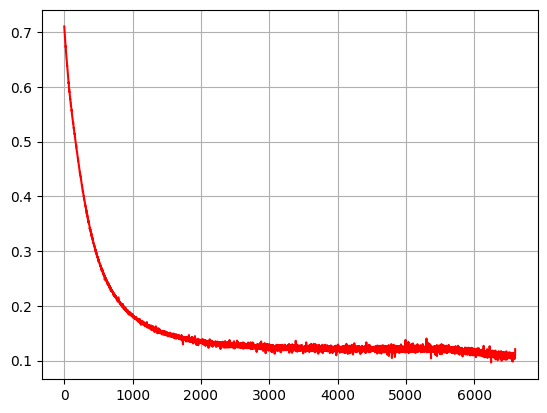

In [28]:
plt.plot(history, c='r')
plt.grid(True)
plt.show();

### 3.3: Model Validation

In [29]:
model.eval()
results = evaluation_run(model, test_loader, device)
results = pd.DataFrame(results, columns=labels)
print(classification_report(test[labels], results, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

 documentary       0.75      0.68      0.71     13096
     western       0.00      0.00      0.00      1032
       drama       0.66      0.40      0.50     13612
       short       0.00      0.00      0.00      5072
      comedy       0.00      0.00      0.00      7446
       adult       0.00      0.00      0.00       590
        news       0.00      0.00      0.00       181
      horror       0.00      0.00      0.00      2204
      sci-fi       0.00      0.00      0.00       646
   talk-show       0.00      0.00      0.00       391
         war       0.00      0.00      0.00       132
       crime       0.00      0.00      0.00       505
       music       0.00      0.00      0.00       731
       sport       0.00      0.00      0.00       431
  reality-tv       0.00      0.00      0.00       883
   adventure       0.00      0.00      0.00       775
   game-show       0.00      0.00      0.00       193
     musical       0.00    

## Section 4: Data Cartography

### 4.1: Cartography computation

In [30]:
cartography = compute_metrics(train_dyn)
train = train.join(cartography)
new_col = pd.DataFrame(train['confidence'] * (1 - train['variability']), columns = ['c*(1-v)'])
premises = train.join(new_col)

### 4.2: Cartography plotting

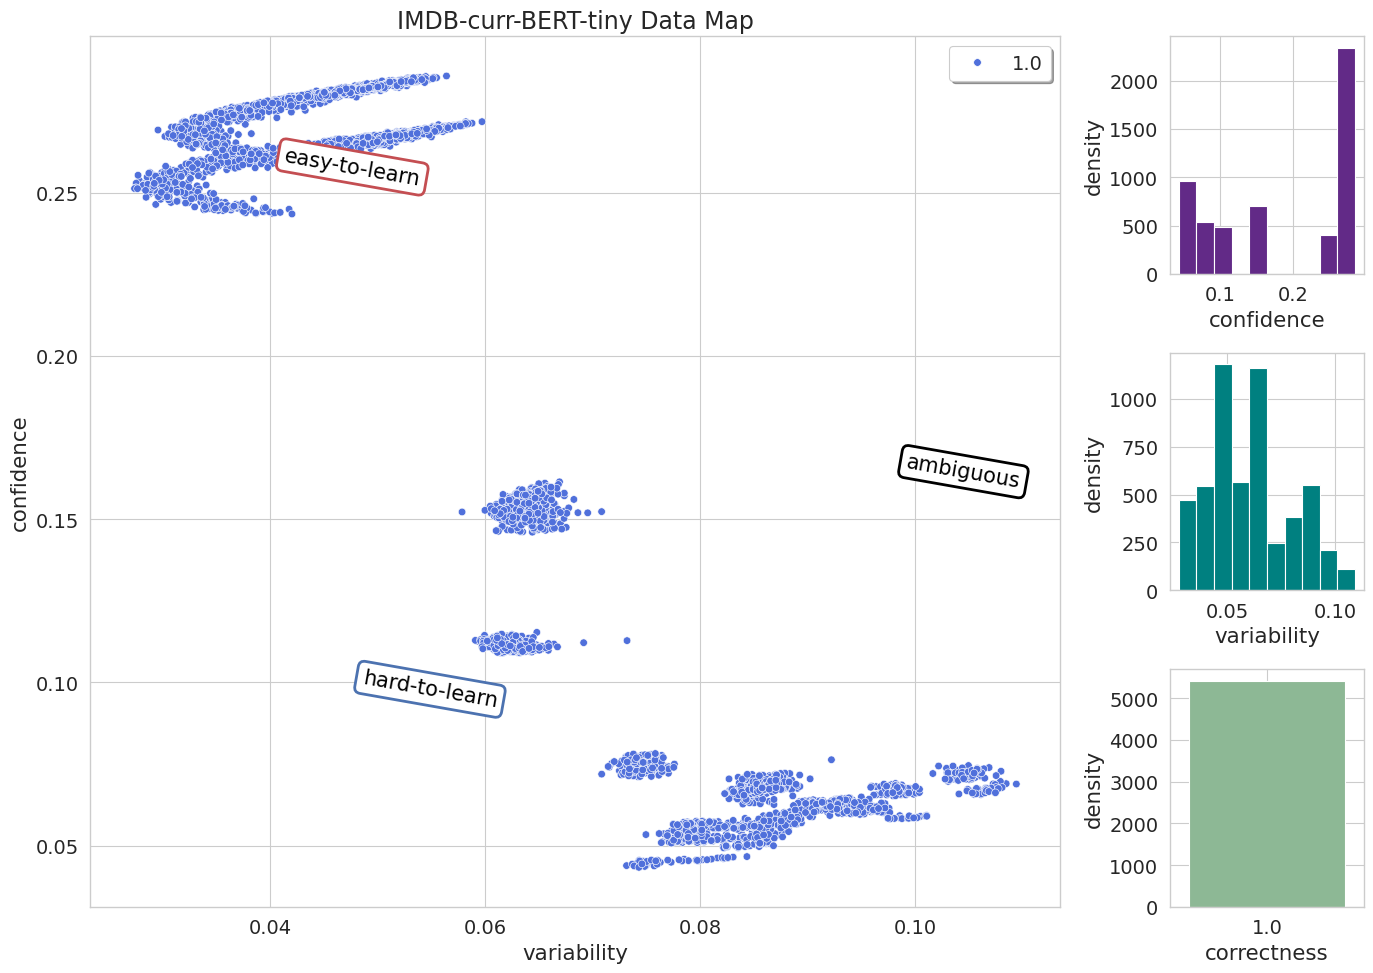

In [31]:
plot_data_map(cartography,plot_dir=os.getcwd(),show_hist=True)

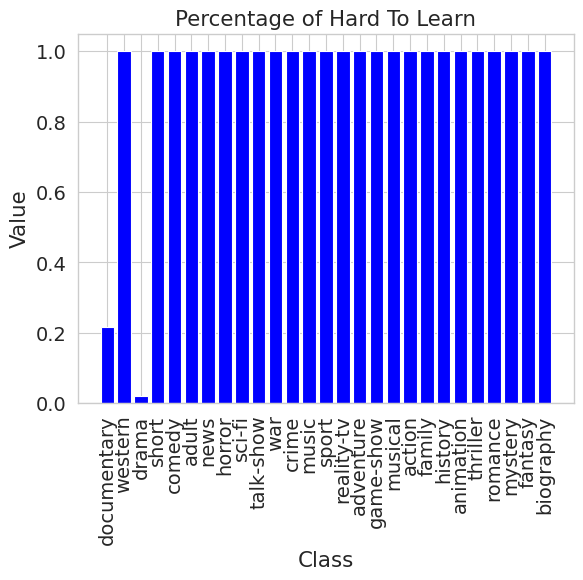

In [41]:
hard_to_learn(premises, labels)

## Section 5: Data Cartography guided model generation

### 5.1: Model definition

In [33]:
model2 = AutoModelForSequenceClassification.from_pretrained(CARD, num_labels = len(labels), problem_type='multi_label_classification')
for param in model2.bert.embeddings.parameters(): # We don't want to train the first layer
    param.requires_grad = False
for param in model2.bert.encoder.parameters():
    param.requires_grad = True
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
optimizer2.zero_grad()
loss_fn2 = torch.nn.BCEWithLogitsLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2: Model instantiation

In [34]:
device2 = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device2)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

### 5.3: Creation of data cartography guided curriculum learning datasets

In [35]:
### Class based curriculum

datasets_curriculum = []
for i in [7, 5, 3, 2, 1, 0]:
  df = pd.DataFrame()
  for label in labels:
    dataset_temp = premises[premises[label] == 1.0]
    dataset_temp = dataset_temp[dataset_temp['c*(1-v)'] >= dataset_temp['c*(1-v)'].quantile(i/10)]
    df = pd.concat([df, dataset_temp], ignore_index=True)
  datasets_curriculum.append(df)

datasets_curriculum = [IMDB_Dataset(ds, tokenizer, max_len=MAX_LEN) for ds in datasets_curriculum]
loaders_curriculum = [DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True) for ds in datasets_curriculum]

## Section 6: Curriculum learning training and validation

### 6.1: Model training

In [36]:
history2 = []
train_dyn2 = {}
c_old = 0
c_max = train_steps
loss_lim = [0.2, 0.15, 0.12, 0.1, 0.08, 0.05]
for i in range(len(loaders_curriculum)):
  his, c_old = trainer(model2, device2, optimizer2, loss_fn2, loaders_curriculum[i], (EPOCHS - len(loaders_curriculum) + i + 1)*2, train_dyn2, c_old, c_max, loss_lim[i])
  history2.extend(his)
  if c_old == c_max:
    break

EPOCH 1/190...
Data Cartography sample generation...
EPOCH 2/190...
Data Cartography sample generation...
EPOCH 3/190...
Data Cartography sample generation...
EPOCH 4/190...
Data Cartography sample generation...
EPOCH 5/190...
Data Cartography sample generation...
EPOCH 6/190...
Data Cartography sample generation...
EPOCH 7/190...
Data Cartography sample generation...
EPOCH 8/190...
Data Cartography sample generation...
EPOCH 9/190...
Data Cartography sample generation...
EPOCH 10/190...
Data Cartography sample generation...
EPOCH 11/190...
Data Cartography sample generation...
EPOCH 12/190...
Data Cartography sample generation...
EPOCH 13/190...
Data Cartography sample generation...
EPOCH 14/190...
Data Cartography sample generation...
EPOCH 15/190...
Data Cartography sample generation...
EPOCH 16/190...
Data Cartography sample generation...
EPOCH 17/190...
Data Cartography sample generation...
EPOCH 18/190...
Data Cartography sample generation...
EPOCH 19/190...
Data Cartography samp

### 6.2: Train loss plotting

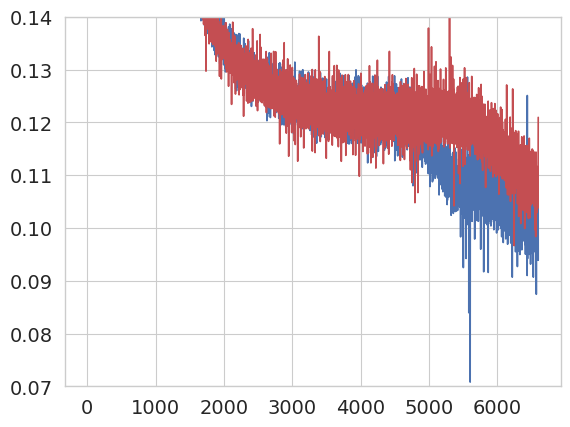

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(history2, c='b')
ax.plot(history, c='r')
ax.set_ylim(0.07, 0.14)
ax.grid(True)
plt.show();

### 6.3: Model evaluation

In [38]:
model2.eval()
results2 = evaluation_run(model2, test_loader, device)
results2 = pd.DataFrame(results2, columns=labels)
print(classification_report(test[labels], results2, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

 documentary       0.71      0.77      0.74     13096
     western       0.00      0.00      0.00      1032
       drama       0.56      0.65      0.60     13612
       short       0.00      0.00      0.00      5072
      comedy       0.00      0.00      0.00      7446
       adult       0.00      0.00      0.00       590
        news       0.00      0.00      0.00       181
      horror       0.00      0.00      0.00      2204
      sci-fi       0.00      0.00      0.00       646
   talk-show       0.00      0.00      0.00       391
         war       0.00      0.00      0.00       132
       crime       0.00      0.00      0.00       505
       music       0.00      0.00      0.00       731
       sport       0.00      0.00      0.00       431
  reality-tv       0.00      0.00      0.00       883
   adventure       0.00      0.00      0.00       775
   game-show       0.00      0.00      0.00       193
     musical       0.00    

#### Baseline model evaluation for comparison

In [39]:
print(classification_report(test[labels], results, zero_division=0.0, target_names = labels))

              precision    recall  f1-score   support

 documentary       0.75      0.68      0.71     13096
     western       0.00      0.00      0.00      1032
       drama       0.66      0.40      0.50     13612
       short       0.00      0.00      0.00      5072
      comedy       0.00      0.00      0.00      7446
       adult       0.00      0.00      0.00       590
        news       0.00      0.00      0.00       181
      horror       0.00      0.00      0.00      2204
      sci-fi       0.00      0.00      0.00       646
   talk-show       0.00      0.00      0.00       391
         war       0.00      0.00      0.00       132
       crime       0.00      0.00      0.00       505
       music       0.00      0.00      0.00       731
       sport       0.00      0.00      0.00       431
  reality-tv       0.00      0.00      0.00       883
   adventure       0.00      0.00      0.00       775
   game-show       0.00      0.00      0.00       193
     musical       0.00    